In [1]:
# Required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed
SEED = 42

### __Data Load / Split / Data type Separation__

In [2]:
# Load data
X = pd.read_csv("../datasets/weather_data_target.csv")
y = X.pop("Dryness")

# Data Spliting 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Define features
numerical_features = ['Temperature', 'Humidity', 'Precipitation (%)', 'UV Index', 'Visibility (km)']
categorical_features = ['Season', 'Cloud Cover', 'Location']

In [3]:
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


---

### __Data Preparation__

##### __Dataset with outliers__

In [4]:
X.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


### __Feature Engineering and Preprocessing__

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('n',StandardScaler(), numerical_features),
        ('c',OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) 
    ],
)

X_train_processed = preprocessor.fit_transform(X_train)
feature_names_out = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_train_processed, columns=feature_names_out)

In [6]:
def distplots(df=X_df,n=8):
    cols = list(df.columns)
    fig, axes = plt.subplots(5, 2, figsize=(15,8))
    plt.tight_layout(pad=3)
    for col, ax in enumerate(axes.flatten()):
        if df[cols[col]].dtypes=='float64':
            sns.boxplot(x=df[cols[col]], ax=ax, color='darkcyan')
        if col>n:
            break;

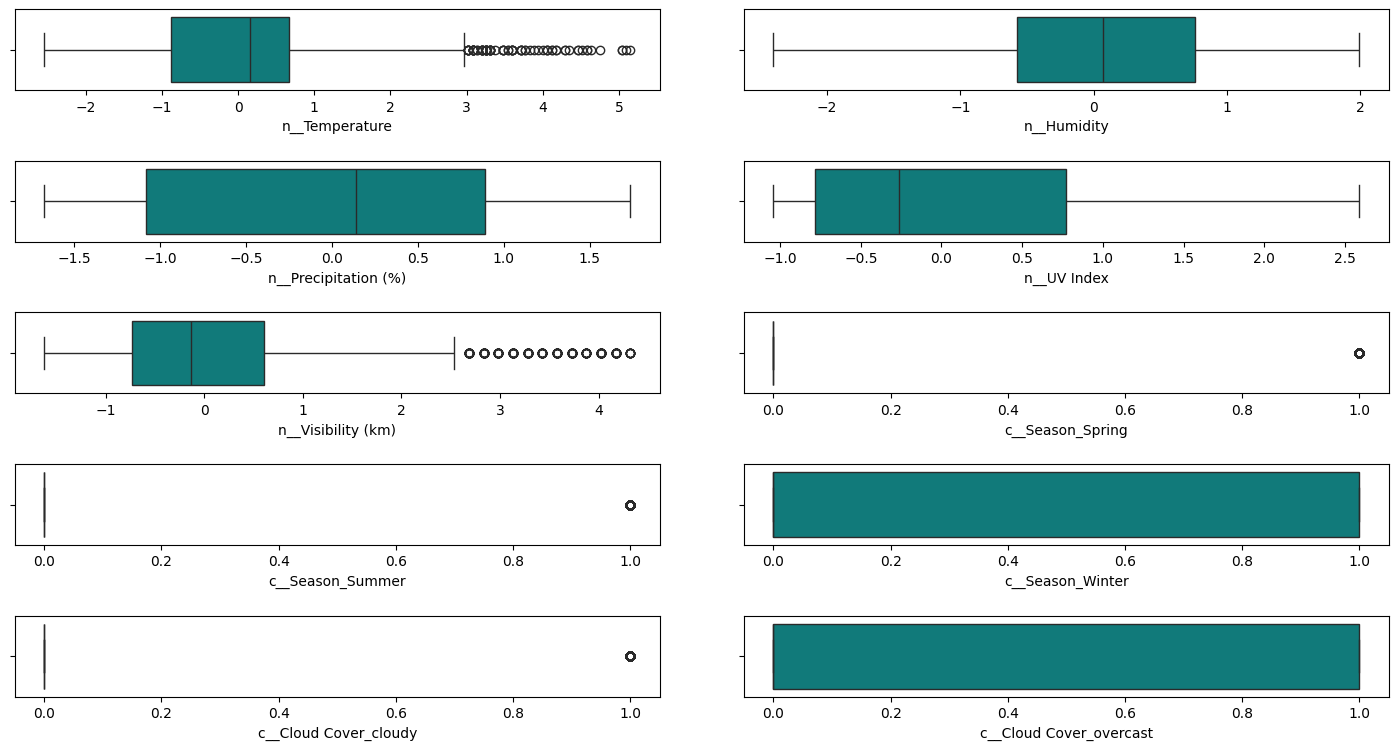

In [7]:
distplots(df=X_df)

In [8]:
y.value_counts()

Dryness
0    12618
1      582
Name: count, dtype: int64

---

#### __Upsampling__

 - Based on the feature target unbalacing

In [9]:
smote = SMOTE(random_state=SEED, )

X_train_upsample, y_train_upsample = smote.fit_resample(X_train_processed, y_train)

In [10]:
y_train_upsample.value_counts()

Dryness
0    10084
1    10084
Name: count, dtype: int64

In [11]:
x_df = pd.DataFrame(X_train_upsample, columns=feature_names_out)
x_df.head()

,n__Temperature,n__Humidity,n__Precipitation (%),n__UV Index,n__Visibility (km),c__Season_Spring,c__Season_Summer,c__Season_Winter,c__Cloud Cover_cloudy,c__Cloud Cover_overcast,c__Cloud Cover_partly cloudy,c__Location_inland,c__Location_mountain
0,0.727984,-0.129706,1.204747,-0.523097,-1.179544,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.248339,1.352488,0.109053,-1.041944,-0.436072,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.498261,-0.524958,-1.331000,1.552291,1.050873,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.589447,0.759610,0.985608,-0.523097,-1.030850,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.076047,-0.129706,-1.362306,-0.782520,0.753484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
def distplots(df=X_train_upsample,n=8):
    cols = list(df.columns)
    fig, axes = plt.subplots(5, 2, figsize=(15,8))
    plt.tight_layout(pad=3)
    for col, ax in enumerate(axes.flatten()):
        if df[cols[col]].dtypes=='float64':
            sns.boxplot(x=df[cols[col]], ax=ax, color='darkcyan')
        if col>n:
            break;

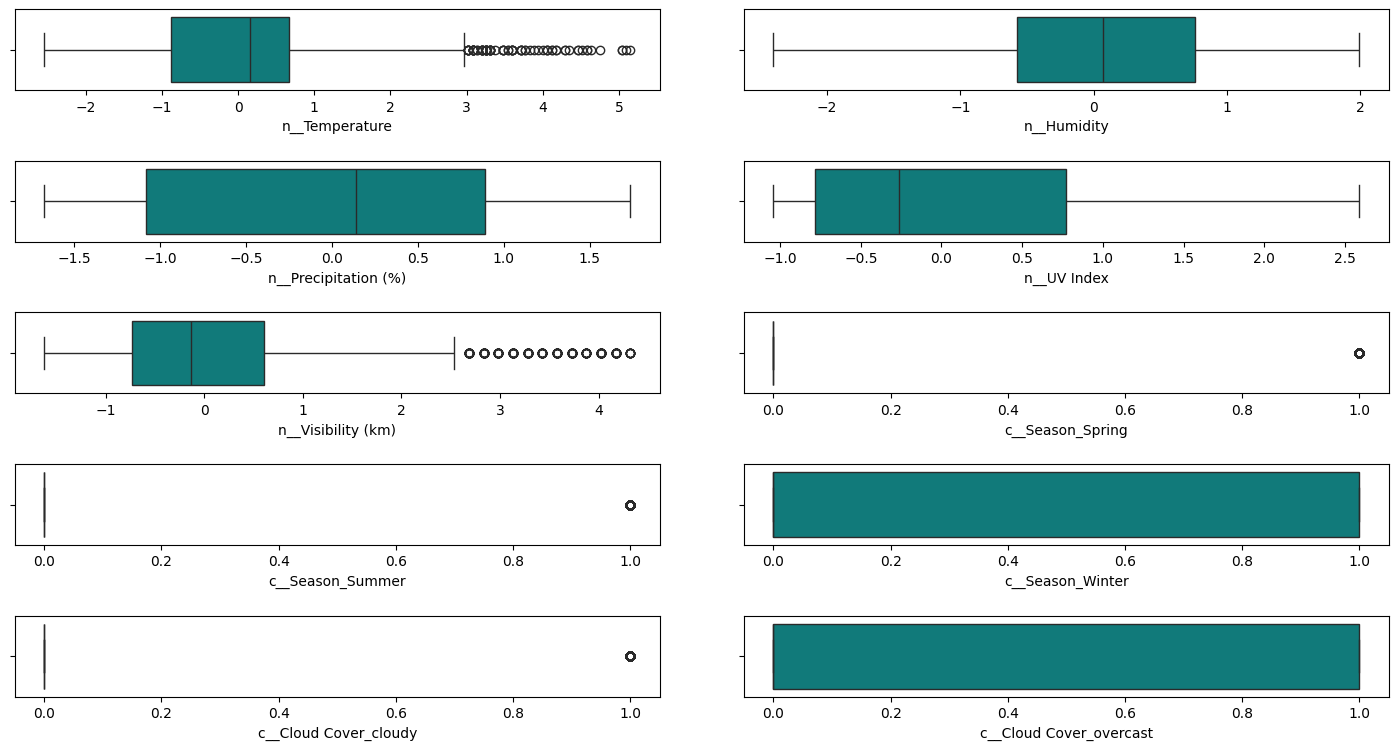

In [13]:
distplots(df=X_df)

In [14]:
# Grid search setup
params = {
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'class_weight': ['balanced', None]
}
# GridSearchCV with pipeline
clf = DecisionTreeClassifier(random_state=SEED)
search = GridSearchCV(estimator=clf, param_grid=params, scoring='precision', cv=5)
search.fit(X_train_upsample, y_train_upsample)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [5, 10], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5]},
             scoring='precision')

In [15]:
# Print best model
print("\nBest Estimator:")
print(search.best_estimator_)


Best Estimator:
DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)


In [16]:
# Define prediction report function
def predict(model, X_train_upsample, y_train_upsample):
    y_pred = model.predict(X_train_upsample)
    acc = accuracy_score(y_train_upsample, y_pred)
    pre = precision_score(y_train_upsample, y_pred)
    rec = recall_score(y_train_upsample, y_pred)
    print(f"accuracy: {acc:.3f}")
    print(f"precision: {pre:.3f}")
    print(f"recall: {rec:.3f}")
    return y_pred

In [17]:
# Evaluate with full data
print("\nFinal Model Evaluation:")
y_predic = predict(search.best_estimator_, X_train_upsample, y_train_upsample)


Final Model Evaluation:
accuracy: 1.000
precision: 1.000
recall: 1.000


In [18]:
# Check overfitting with cross-validation
cv_scores = cross_val_score(search.best_estimator_, X_train_upsample, y_train_upsample, cv=5, scoring='precision')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Average precision: {cv_scores.mean():.4f}")


Cross-validation scores: [1. 1. 1. 1. 1.]
Average precision: 1.0000


---

### __Evaluating on Unseen Data__

In [19]:
X_test_processed = preprocessor.transform(X_test)
y_test_pred = search.best_estimator_.predict(X_test_processed)
print("Test set performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")

Test set performance:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


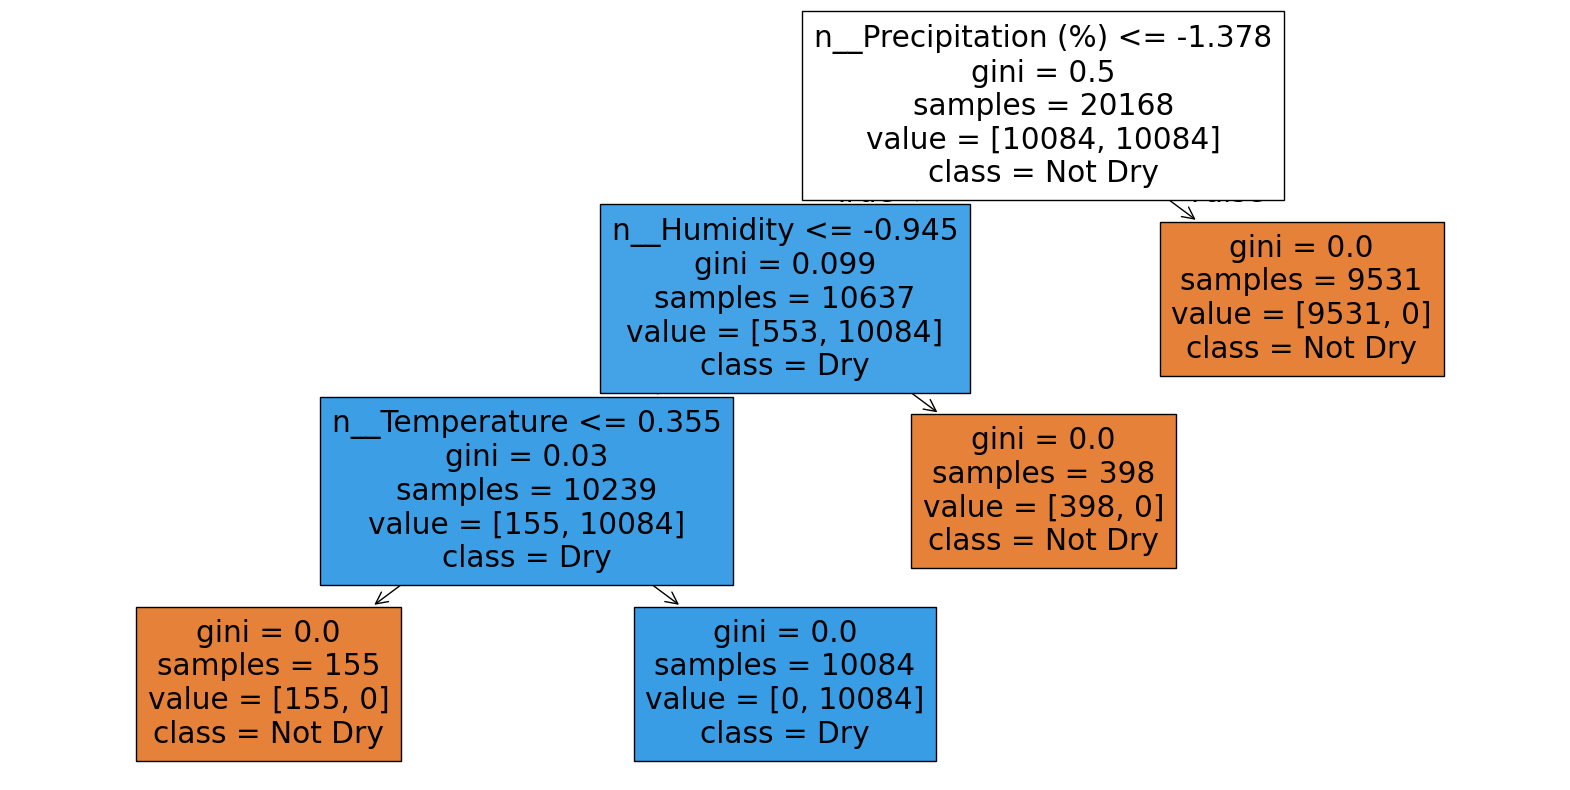

In [20]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(
    search.best_estimator_,
    filled=True,
    feature_names=feature_names_out,  
    class_names=["Not Dry", "Dry"]
)
plt.show()



The Gini index measures the __impurity__ of a __node__ (how mixed the classes are).
In this case, the Gini value for Precipitation is 0.5, indicating a perfect mix of classes __(maximum impurity)__.
In contrast, Humidity and Temperature have much lower Gini values (0.099 and 0.03), suggesting that their nodes are __purer and mostly contain one class__.
Therefore, Precipitation leads to the most uncertain split and contributes to confusing decision boundaries, while the other features offer more decisive class separation.

---

### __The result brought a clear overfitting situation__

 - The plan now is to check the correlation between the numeric features

In [21]:
df_full = X.copy()
df_full['Dryness'] = y
df_full.corr(numeric_only=True)['Dryness'].sort_values(ascending=False)


Dryness                 1.000000
UV Index                0.227894
Temperature             0.195797
Visibility (km)         0.137266
Atmospheric Pressure    0.082440
Wind Speed             -0.146509
Precipitation (%)      -0.330406
Humidity               -0.359059
Name: Dryness, dtype: float64

---

#### __SMOTE can be the vilain__
 * Now I'll train without the upsampling

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('n',StandardScaler(), numerical_features, ),
        ('c',OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) 
    ],
)

X_train_processed = preprocessor.fit_transform(X_train)
feature_names_out = preprocessor.get_feature_names_out()
X_df = pd.DataFrame(X_train_processed, columns=feature_names_out)

In [23]:
# Grid search setup
params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', None]
}
# GridSearchCV with pipeline
clf = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
search = GridSearchCV(estimator=clf, param_grid=params, scoring='precision', cv=5)
search.fit(X_train_processed, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='precision')

In [24]:
# Print best model
print("\nBest Estimator:")
print(search.best_estimator_)


Best Estimator:
DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)


In [25]:
# Define prediction report function
def predict_performance(model, X_train_processed, y_train, data_type="training"):
    y_pred = model.predict(X_train_processed)
    acc = accuracy_score(y_train, y_pred)
    pre = precision_score(y_train, y_pred)
    rec = recall_score(y_train, y_pred)
    print(f"{data_type} set performance:")
    print(f"accuracy: {acc:.3f}")
    print(f"precision: {pre:.3f}")
    print(f"recall: {rec:.3f}")
    return y_pred

In [26]:
# Evaluate with training data (without SMOTE)
print("\nFinal Model Evaluation (without SMOTE on original training data):")
y_pred_train_no_smote = predict_performance(search.best_estimator_, X_train_processed, y_train, "Training")


Final Model Evaluation (without SMOTE on original training data):
Training set performance:
accuracy: 1.000
precision: 1.000
recall: 1.000


In [27]:
# Check overfitting with cross-validation (without SMOTE)
cv_scores_no_smote = cross_val_score(search.best_estimator_, X_train_processed, y_train, cv=5, scoring='precision')
print(f"\nCross-validation scores (without SMOTE): {cv_scores_no_smote}")
print(f"Average precision (without SMOTE): {cv_scores_no_smote.mean():.4f}")


Cross-validation scores (without SMOTE): [1. 1. 1. 1. 1.]
Average precision (without SMOTE): 1.0000


---
### __Evaluating on Unseen Data (without SMOTE)__


Test set performance (without SMOTE trained model):
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


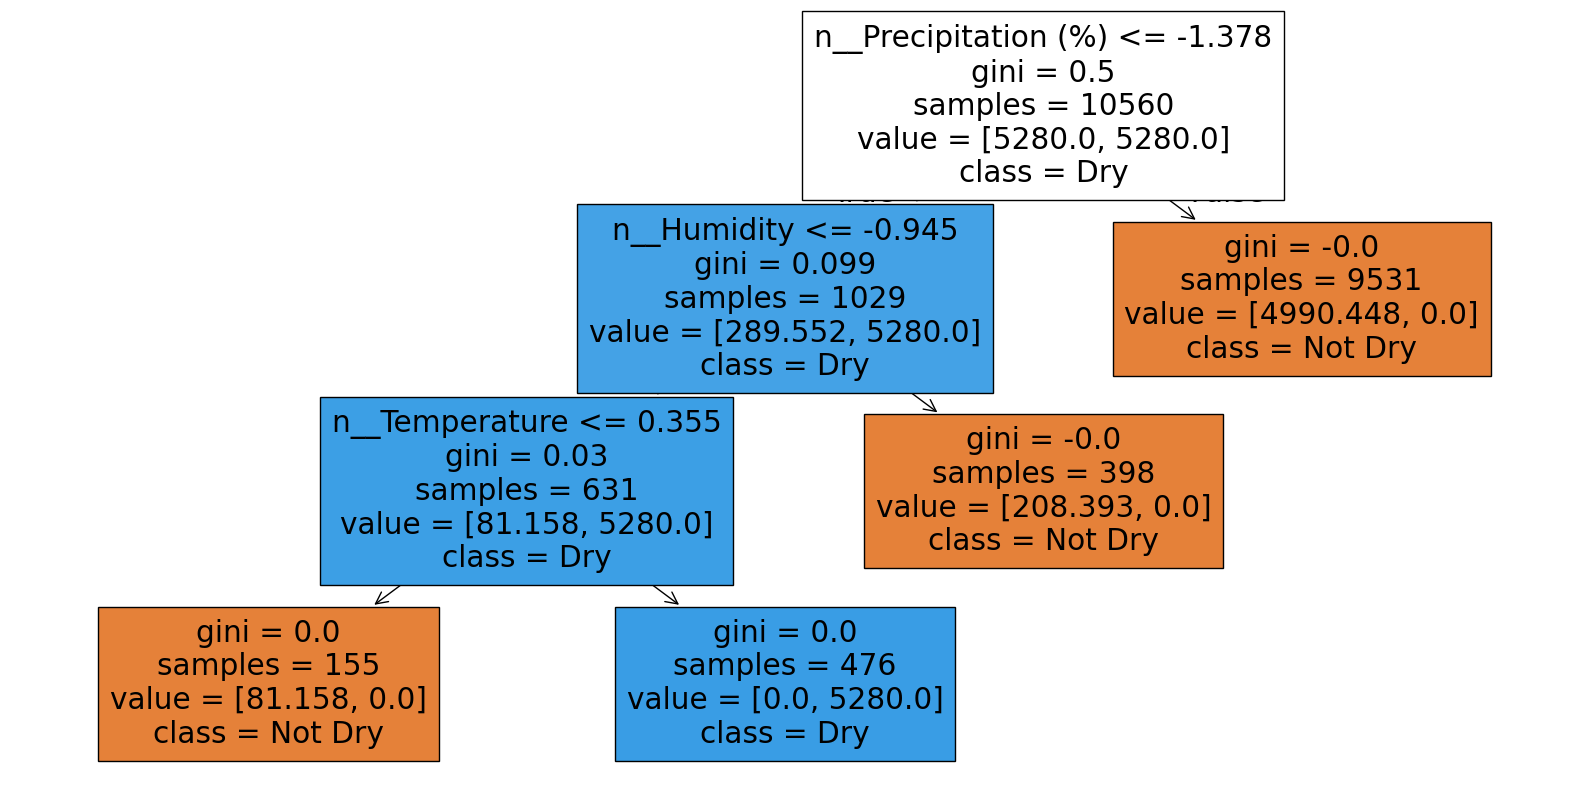

In [28]:

X_test_processed = preprocessor.transform(X_test) # Transform test data using the fitted preprocessor
y_test_pred_no_smote = search.best_estimator_.predict(X_test_processed)

print("\nTest set performance (without SMOTE trained model):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_no_smote):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred_no_smote):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred_no_smote):.3f}")

# Plotting the best decision tree without SMOTE
plt.figure(figsize=(20, 10))
plot_tree(
    search.best_estimator_,
    filled=True,
    feature_names=feature_names_out,  
    class_names=["Not Dry", "Dry"]
)
plt.show()

# Key Findings

The initial exploration and model training for predicting "Dryness" in weather data revealed a highly unusual and insightful outcome.

#### 1. Perfect Training and Test Set Performance:
Both the initial Decision Tree model (with and without SMOTE) achieved **100% accuracy, precision, and recall on the training data**, and surprisingly, **100% accuracy, precision, and recall on the unseen test data** as well. This level of perfect performance in a real-world predictive task is highly anomalous and strongly indicative of an underlying issue rather than genuinely flawless predictive power.

#### 2. Rule-Based Target Definition (Data Leakage Identified):
With a closer inspection, it was determined that the "Dryness" target variable itself is **defined by a deterministic, rule-based logic** using a combination of "Precipitation (%)", "Humidity", and "Temperature" thresholds:
* **Dry:** `Precipitation (%) < bottom 10% of the dataset` AND `Humidity < 40` AND `Temperature > 25`
* **Not Dry:** Otherwise

#### 3. Impact on Model Evaluation:
The perfect model performance is a direct consequence of the target variable being an __explicit function of the input features__. The Decision Tree model effectively "discovered" and replicated this underlying rule. This scenario highlights a critical case of **data leakage**, where the information directly defining the target is explicitly present and easily discernible within the features.

#### 4. SMOTE's Role:
Even though SMOTE was initially applied to address perceived class imbalance, its application became redundant given the deterministic nature of the target variable. The synthetic samples generated by SMOTE would merely conform to the same deterministic rule, not introduce new, complex patterns for the model to learn, nor genuinely balance a naturally imbalanced distribution.

---

# Conclusion

The objective of predicting "Dryness" using the provided weather dataset initially yielded a seemingly perfect predictive model. However, a deeper investigation revealed that this exceptionally high performance stems from the fundamental structure of the dataset rather than the model's advanced learning capabilities on complex, unpredictable patterns.

The "Dryness" target variable is not a naturally occurring, statistically inferred label, but rather a **pre-defined, rule-based classification** derived directly from the 'Precipitation (%)', 'Humidity', and 'Temperature' features. The Decision Tree model, by its very nature, excels at identifying such explicit decision boundaries and effectively "memorized" this inherent rule present in the data.

Consequently, the model's perfect scores do not reflect its ability to generalize to truly unknown, complex meteorological conditions but rather its success in reverse-engineering the pre-existing classification logic within this specific dataset.

For future predictive modeling tasks, it is crucial to ensure that the target variable represents an outcome to be *predicted* based on underlying statistical relationships, not an outcome that is *defined* by the input features. This understanding is paramount for building robust, generalizable machine learning models that provide genuine insights and predictive power for real-world phenomena.

## Challenges Faced During the Analysis

- **Data Leakage Risk**
  - Initially applied SMOTE before train-test split, which leaked test information into the model.

- **Overfitting Issue**
  - Decision Tree produced perfect scores (accuracy, precision, recall = 1.0), even with cross-validation and test set.

- **Misleading SMOTE Output**
  - SMOTE created overly separable synthetic samples, making it too easy for the model to learn and overfit.

- **Feature Name Confusion**
  - Transformed features from `ColumnTransformer` had prefix labels (e.g., `'n__Temperature'`) causing mismatches and plotting issues.

- **GridSearch Errors**
  - Faced errors like missing `param_grid` or using invalid parameter names due to pipeline changes.

- **DataFrame vs. Numpy Array Issues**
  - Attempted to use `.head()` or `.columns` on arrays, which led to errors.

- **Unrealistic Model Evaluation**
  - Despite correct implementation, all evaluation scores were unrealistically perfect, indicating the model wasn’t learning generalizable patterns.

- **Debugging Frustration**
  - Multiple stages of code refactoring, SMOTE repositioning, and feature reprocessing were needed to stabilize the workflow.
